In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf

In [2]:
# 이미지 한개 불러오기(총 2개)
bicubic_folder = "./bicubic_sr/"
hr_folder = "./hr/"

hr = Image.open(hr_folder+"frame1655.png")
bicubic_sr = Image.open(bicubic_folder+"frame1655.png")

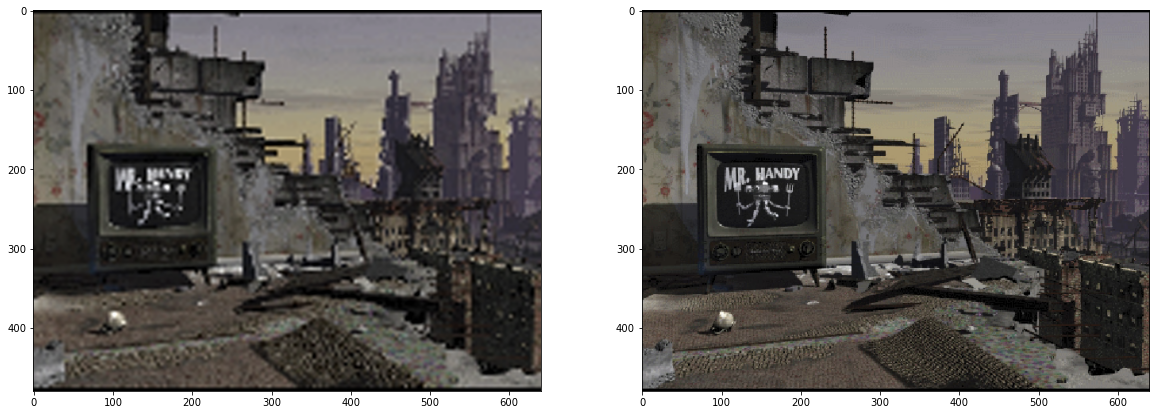

In [3]:
## 이미지 비교
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(bicubic_sr)

plt.subplot(1,2,2)
plt.imshow(hr)

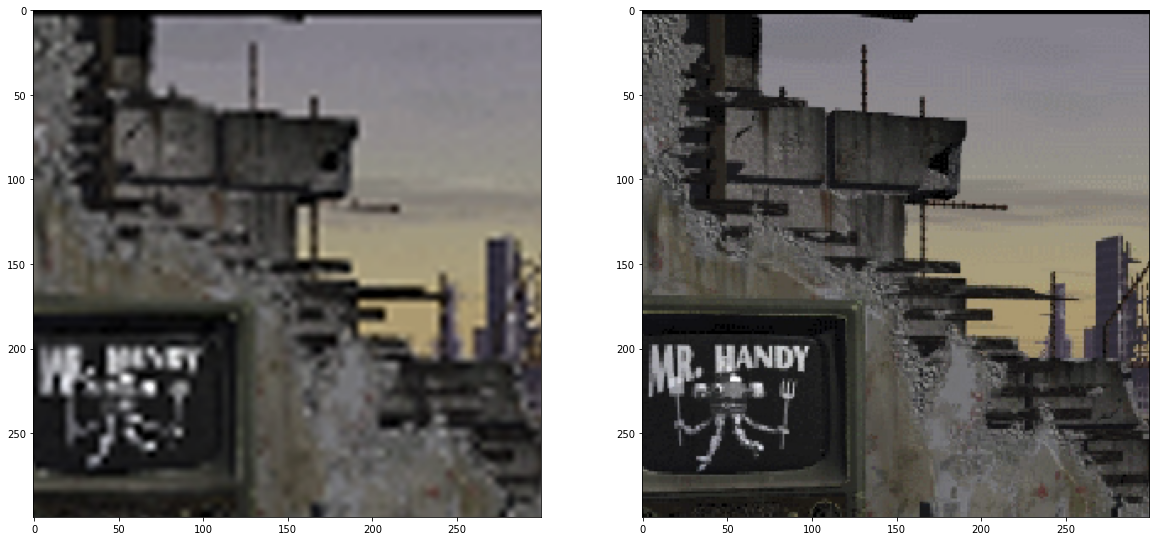

In [4]:
## crop해서 어느정도 화질이 구려지는지 확인해보자
c = np.array(hr)
a = np.array(bicubic_sr)

def crop(img, z, x=300,y=300):
    return img[z[0]:(z[0]+x), z[1]:(z[1]+y), :]

z = (0,100)
bicubic_crop = crop(a,z)
hr_crop = crop(c,z)

## 이미지 비교
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(bicubic_crop)

plt.subplot(1,2,2)
plt.imshow(hr_crop)

In [2]:
## hr, bicubic_sr 을 넘파이배열로 읽어서 리스트에 각각 저장

# 불러오기1
import natsort

# low 리스트 불러오기
bicubic_folder = "./bicubic_sr/"
hr_folder = "./hr/"

l = os.listdir(bicubic_folder)
if ".DS_Store" in l:
    l.remove(".DS_Store")
    
# high 리스트 불러오기
h = os.listdir(hr_folder)
if ".DS_Store" in h:
    h.remove(".DS_Store")
    
B_SR = []
HR = []

l = natsort.natsorted(l)
h = natsort.natsorted(h)

for x in l[1000:1500]: # 양이 많아서 일단 1000개로 줄임
    img = cv2.imread(bicubic_folder+x)
    q = np.asarray(img)
    B_SR.append(q)

for x in h[1000:1500]: # 양이 많아서 일단 1000개로 줄임
    img = cv2.imread(hr_folder+x)
    w = np.asarray(img)
    HR.append(w)

In [3]:
# 1/255화

B_SR = tf.cast(B_SR, tf.float32) /255.
HR = tf.cast(HR, tf.float32) /255.

## 커널 오류는 메모리 문제였던걸로 판명

Metal device set to: Apple M1


2022-04-08 12:05:04.191001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-08 12:05:04.191217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [38]:
# 넘파이배열로 각각 저장하자(또 오류나면 곤란)
# 전체 이미지 해보니깐 각각 28기가 정도로 저장되서 곤란
#np.save('B_SR', B_SR)
#np.save('HR', HR)

In [4]:
print(HR.shape)
print(B_SR.shape)

(500, 480, 640, 3)
(500, 480, 640, 3)


In [5]:
## train, valid 만들기
# 전체 이미지 수 3824개 중 1000개 중 800:200 으로 분리

# train
B_SR_t = B_SR[:400]
HR_t = HR[:400]

# validation
B_SR_v = B_SR[400:]
HR_v = HR[400:]

In [6]:
## 인풋에 들어갈 train,valid 데이터셋을 BatchDataset으로 바꿔보자
train = tf.data.Dataset.from_tensor_slices((B_SR_t, HR_t))
valid = tf.data.Dataset.from_tensor_slices((B_SR_v, HR_v))

In [7]:
# prefetch화
train2 = train.prefetch(1)
valid2 = valid.prefetch(1)

In [8]:
# prefetch화된 훈련, 검증데이터 형태 확인
print(train2)
print(valid2)

<PrefetchDataset shapes: ((480, 640, 3), (480, 640, 3)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((480, 640, 3), (480, 640, 3)), types: (tf.float32, tf.float32)>


In [9]:
# shuffle, batchsize 지정
# batch_size 만큼 이미지들을 한꺼번에 학습
# 버퍼사이즈만큼 셔플링(학습데이터보다 같거나 커야 전부 잘 섞여요)
train3 = train2.shuffle(buffer_size=1000).batch(10)
valid3 = valid2.batch(10)

In [10]:
print(train3)
print(valid3)

<BatchDataset shapes: ((None, 480, 640, 3), (None, 480, 640, 3)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 480, 640, 3), (None, 480, 640, 3)), types: (tf.float32, tf.float32)>


In [11]:
## srcnn 구현
import tensorflow as tf
from tensorflow.keras import layers

srcnn = tf.keras.Sequential()

srcnn.add(layers.Conv2D(128, 9, padding="same", input_shape=(None,None,3)))
srcnn.add(layers.ReLU())

srcnn.add(layers.Conv2D(64, 5, padding="same"))
srcnn.add(layers.ReLU())

srcnn.add(layers.Conv2D(3, 5 ,padding="same"))

srcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   31232     
                                                                 
 re_lu (ReLU)                (None, None, None, 128)   0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    204864    
                                                                 
 re_lu_1 (ReLU)              (None, None, None, 64)    0         
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     4803      
                                                                 
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 컴파일 후 훈련
srcnn.compile(optimizer="adam",loss="mse")
srcnn.fit(train3,validation_data = valid3, epochs=10) # epoch 미정

Epoch 1/10


2022-04-08 12:08:49.243337: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-08 12:08:49.243424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/40 [======>.......................] - ETA: 3:07 - loss: 0.0355

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b3305cc0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


37/40 [==========================>...] - ETA: 19s - loss: 0.0136

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2d24db350>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


40/40 [==============================] - ETA: 0s - loss: 0.0129

2022-04-08 12:13:04.669222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 274s 7s/step - loss: 0.0129 - val_loss: 0.0044
Epoch 2/10


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c550f0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 3/40 [=>............................] - ETA: 4:16 - loss: 0.0041

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c5ac70>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


10/40 [======>.......................] - ETA: 3:21 - loss: 0.0039

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2d257d360>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


14/40 [=========>....................] - ETA: 2:53 - loss: 0.0039

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c5c450>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


20/40 [==============>...............] - ETA: 2:15 - loss: 0.0038

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c5b1d0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


23/40 [================>.............] - ETA: 1:54 - loss: 0.0038

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2d2580ce0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


32/40 [=======================>......] - ETA: 54s - loss: 0.0037 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c59ee0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


40/40 [==============================] - 290s 7s/step - loss: 0.0037 - val_loss: 0.0036
Epoch 3/10
24/40 [=================>............] - ETA: 1:55 - loss: 0.0033

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2d257c6f0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


25/40 [=================>............] - ETA: 1:47 - loss: 0.0033

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c53100>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


27/40 [===================>..........] - ETA: 1:33 - loss: 0.0033

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2d257ab90>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


34/40 [========================>.....] - ETA: 43s - loss: 0.0033

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2d257d200>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


36/40 [==========================>...] - ETA: 28s - loss: 0.0033

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2d257d290>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


40/40 [==============================] - 312s 8s/step - loss: 0.0033 - val_loss: 0.0033
Epoch 4/10
 2/40 [>.............................] - ETA: 4:33 - loss: 0.0033

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2d257b300>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 7/40 [====>.........................] - ETA: 3:47 - loss: 0.0033

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2d2578f20>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 9/40 [=====>........................] - ETA: 3:28 - loss: 0.0033

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2d257aeb0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


15/40 [==========>...................] - ETA: 2:50 - loss: 0.0034

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2d257ce70>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


20/40 [==============>...............] - ETA: 2:18 - loss: 0.0035

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x13be218d0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


22/40 [===============>..............] - ETA: 2:03 - loss: 0.0034

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf39060>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


27/40 [===================>..........] - ETA: 1:29 - loss: 0.0034

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c65b80>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


40/40 [==============================] - 296s 7s/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/10
 3/40 [=>............................] - ETA: 4:23 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c65910>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 9/40 [=====>........................] - ETA: 3:33 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf3e2d0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


12/40 [========>.....................] - ETA: 3:11 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf334d0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


13/40 [========>.....................] - ETA: 3:02 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf397d0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


28/40 [====================>.........] - ETA: 1:24 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf3b200>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


32/40 [=======================>......] - ETA: 56s - loss: 0.0030 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6595bf0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


33/40 [=======================>......] - ETA: 49s - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c66c70>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


35/40 [=========================>....] - ETA: 35s - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x2b6c672b0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x2b6c6bc20>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
    

38/40 [===========================>..] - ETA: 14s - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b659e310>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


39/40 [============================>.] - ETA: 7s - loss: 0.0030 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c660c0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


40/40 [==============================] - 304s 8s/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/10
 1/40 [..............................] - ETA: 4:46 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6597130>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 3/40 [=>............................] - ETA: 4:18 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf35f10>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


20/40 [==============>...............] - ETA: 2:23 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf358d0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


40/40 [==============================] - 304s 8s/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/10
 1/40 [..............................] - ETA: 4:35 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf35de0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 5/40 [==>...........................] - ETA: 3:56 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c68400>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


21/40 [==============>...............] - ETA: 2:12 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c65440>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


23/40 [================>.............] - ETA: 1:58 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6596a80>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


35/40 [=========================>....] - ETA: 34s - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b659cfc0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


38/40 [===========================>..] - ETA: 13s - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c67df0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


40/40 [==============================] - 300s 8s/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/10
 2/40 [>.............................] - ETA: 5:40 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c68cb0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 7/40 [====>.........................] - ETA: 4:47 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c66960>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 8/40 [=====>........................] - ETA: 4:33 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf31ef0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


10/40 [======>.......................] - ETA: 4:11 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c608e0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


11/40 [=======>......................] - ETA: 4:00 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf315b0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


12/40 [========>.....................] - ETA: 3:52 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b659ca60>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


14/40 [=========>....................] - ETA: 3:36 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf3d8b0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


15/40 [==========>...................] - ETA: 3:27 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15d064660>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


16/40 [===========>..................] - ETA: 3:17 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15d05ed50>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


21/40 [==============>...............] - ETA: 2:43 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x15bf31930>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x15bf3dec0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
    

22/40 [===============>..............] - ETA: 2:34 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf31f10>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


23/40 [================>.............] - ETA: 2:24 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf31e50>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


24/40 [=================>............] - ETA: 2:14 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c60560>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


29/40 [====================>.........] - ETA: 1:30 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b659f580>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


30/40 [=====================>........] - ETA: 1:21 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf312f0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


40/40 [==============================] - 345s 9s/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/10
 1/40 [..............................] - ETA: 4:56 - loss: 0.0029

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf34f20>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 3/40 [=>............................] - ETA: 4:17 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b65a1a60>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 5/40 [==>...........................] - ETA: 3:59 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf32540>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 8/40 [=====>........................] - ETA: 3:43 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf31190>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 9/40 [=====>........................] - ETA: 3:35 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf3a9a0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


10/40 [======>.......................] - ETA: 3:26 - loss: 0.0031

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf3a9a0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


11/40 [=======>......................] - ETA: 3:17 - loss: 0.0031

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b659f3a0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


13/40 [========>.....................] - ETA: 3:03 - loss: 0.0031

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf2f6d0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


14/40 [=========>....................] - ETA: 2:55 - loss: 0.0031

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b659dc80>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


16/40 [===========>..................] - ETA: 2:43 - loss: 0.0031

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf3ccd0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


17/40 [===========>..................] - ETA: 2:35 - loss: 0.0031

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c659e0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


19/40 [=============>................] - ETA: 2:23 - loss: 0.0031

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6c62c30>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


21/40 [==============>...............] - ETA: 2:10 - loss: 0.0031

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf323c0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


26/40 [==================>...........] - ETA: 1:38 - loss: 0.0031

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b6599690>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


29/40 [====================>.........] - ETA: 1:17 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b65947c0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


31/40 [======================>.......] - ETA: 1:03 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b659b390>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


36/40 [==========================>...] - ETA: 28s - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b659f9d0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


37/40 [==========================>...] - ETA: 20s - loss: 0.0031

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf333e0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


40/40 [==============================] - 301s 8s/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/10
 1/40 [..............................] - ETA: 4:50 - loss: 0.0031

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b65a2c10>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 3/40 [=>............................] - ETA: 4:09 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x15bf393e0>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


 5/40 [==>...........................] - ETA: 3:54 - loss: 0.0030

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2b65a0950>
    label = <none> 
    device = <AGXG13GDevice: 0x12c36d800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x15c82ea00>
        label = <none> 
        device = <AGXG13GDevice: 0x12c36d800>
            name = Apple M1 
    retainedReferences = 1


40/40 [==============================] - 304s 8s/step - loss: 0.0031 - val_loss: 0.0031


In [13]:
# 모델 저장
srcnn.save("srcnn.h5")

In [3]:
# 모델 불러오기
srcnn2 = tf.keras.models.load_model("./model/srcnn.h5")

srcnn2.summary()

Metal device set to: Apple M1


2022-04-18 15:23:26.345219: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-18 15:23:26.345703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   31232     
                                                                 
 re_lu (ReLU)                (None, None, None, 128)   0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    204864    
                                                                 
 re_lu_1 (ReLU)              (None, None, None, 64)    0         
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     4803      
                                                                 
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


In [5]:
## frame1655.png 로 테스트 해보자
# bicubic srcnn hr 순으로 비교해서 보여주자

# hr 불러오기 640 480
hr_folder = "./hr/"
img2 = cv2.imread(hr_folder+"frame1655.png")
hr = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
hr = np.asarray(img2)

# bicubic 불러오기 640 480 # bicubic축소 +  bicubic확장 한 이미지라 화질이 안좋음
bicubic_folder = "./bicubic_sr/"
img = cv2.imread(bicubic_folder+"frame1655.png")
hr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bicubic_sr = np.asarray(img)
bicubic_sr = cv2.cvtColor(bicubic_sr, cv2.COLOR_BGR2RGB)

In [7]:
# srcnn_sr 불러오기
def apply_srcnn(x):
    sr = srcnn2.predict(x[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    
    return np.array(sr[0].astype(np.uint8))

srcnn_sr = apply_srcnn(bicubic_sr)
#srcnn_sr = cv2.cvtColor(srcnn_sr, cv2.COLOR_BGR2RGB)

In [8]:
# crop 함수
def crop(img, z, x=300,y=300):
    return img[z[0]:(z[0]+x), z[1]:(z[1]+y), :]

Text(0.5, 1.0, 'hr')

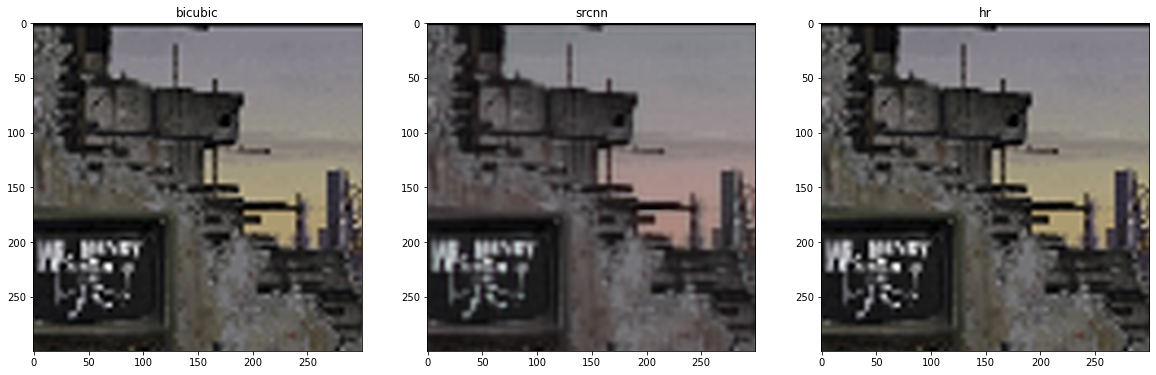

In [9]:
# 자세히 시각화하기 위해 3개 영역 잘라내기
# 아래는 잘라낸 부분의 좌상단 좌표 3개

z = (0,100)

bicubic_crop = crop(bicubic_sr,z)
srcnn_crop = crop(srcnn_sr,z)
hr_crop = crop(hr,z)
## 이미지 비교
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(bicubic_crop)
plt.title("bicubic")

plt.subplot(1,3,2)
plt.imshow(srcnn_crop)
plt.title("srcnn")

plt.subplot(1,3,3)
plt.imshow(hr_crop)
plt.title("hr")

In [7]:
## ssim 을 이용해서 어느정도 차이가 나는지 확인
from skimage.metrics import structural_similarity as ssim

In [8]:
hr_gray = cv2.cvtColor(hr, cv2.COLOR_BGR2GRAY)
bicubic_gray = cv2.cvtColor(bicubic_sr, cv2.COLOR_BGR2GRAY)
srcnn_gray = cv2.cvtColor(srcnn_sr, cv2.COLOR_BGR2GRAY)

In [9]:
(score, diff) = ssim(bicubic_gray, hr_gray, full=True)
diff = (diff * 255).astype("uint8")

(score2, diff2) = ssim(srcnn_gray, hr_gray, full=True)
diff2 = (diff2 * 255).astype("uint8")


print("bicubic_SSIM: {}".format(score))
print("fsrcnn_SSIM: {}".format(score2))

bicubic_SSIM: 0.6548441776305071
fsrcnn_SSIM: 0.653858646285684


In [10]:
## psnr 을 이용해서 어느정도 차이가 나는지 확인
import math

def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 ) #MSE 구하는 코드
    print("mse :", mse)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    print("psnr :", 20 * math.log10(PIXEL_MAX / math.sqrt(mse))) #PSNR구하는 코드

    
print("bicubic vs hr")
dif = psnr(hr,bicubic_sr)

print("========================")

print("srcnn vs hr")
dif2 = psnr(hr,srcnn_sr)

bicubic vs hr
mse : 52.528323567708334
psnr : 30.926868202763277
fsrcnn vs hr
mse : 52.44173611111111
psnr : 30.93403300065827


In [ ]:
cv2.imshow("diff",diff)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

In [ ]:
cv2.imshow("diff2",diff2)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)